# "Lichess" Chess Games Analysis

## 1. Introduction

In this project, I’m analyzing a dataset of 1,000,000 chess games played on **Lichess.org** over a single day. 
My goal is to understand in-game patterns and strategic decisions using features like time control, opening choice, Elo ratings, and match outcomes.

Specifically, I want to:
- Understand the major differences in the Chess games formats (Rapid/Blitz/Bullet)
- Identify the most common openings
- Identify the most effective openings
- Focus on beginner/low intermediate elo to determine easy openings to learn and make recommendations

This notebook documents my full exploration process — from loading and cleaning the data to engineering new features and generating new insights.

## 2. Data Loading & Exploratory Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import json
import plotly.graph_objects as go
import utils
from importlib import reload

In [7]:
df = pd.read_parquet("../data/chess_data.parquet")

In [8]:
df.info()
print("\n")
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991410 entries, 0 to 991409
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Event        991410 non-null  object
 1   WhiteElo     991410 non-null  int32 
 2   BlackElo     991410 non-null  int32 
 3   Result       991410 non-null  object
 4   Opening      991410 non-null  object
 5   Termination  991410 non-null  object
 6   ECO          991410 non-null  object
dtypes: int32(2), object(5)
memory usage: 45.4+ MB




,Event,WhiteElo,BlackElo,Result,Opening,Termination,ECO
0,Bullet,2238,2254,0-1,Mieses Opening,Time forfeit,A00
1,Bullet,1725,1719,1-0,Ware Opening: Crab Variation,Time forfeit,A00
2,Bullet,2031,1998,0-1,Van't Kruijs Opening,Normal,A00
3,Bullet,1524,1518,1-0,Benoni Defense: Old Benoni,Normal,A43
4,Blitz,1800,1698,0-1,Caro-Kann Defense: Panov Attack,Time forfeit,B13


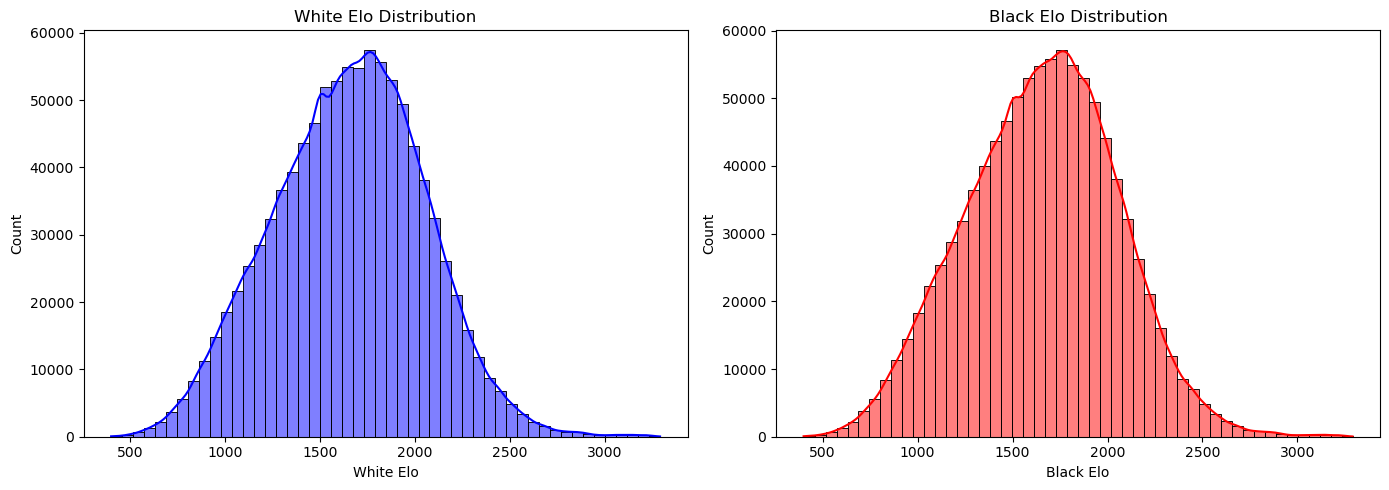

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['WhiteElo'], kde=True, color='blue', bins=50, ax=axes[0])
axes[0].set_title('White Elo Distribution')
axes[0].set_xlabel('White Elo')

sns.histplot(df['BlackElo'], kde=True, color='red', bins=50, ax=axes[1])
axes[1].set_title('Black Elo Distribution')
axes[1].set_xlabel('Black Elo')

plt.tight_layout()
plt.show()

## 2.1. Understand the Distribution of Game Formats 

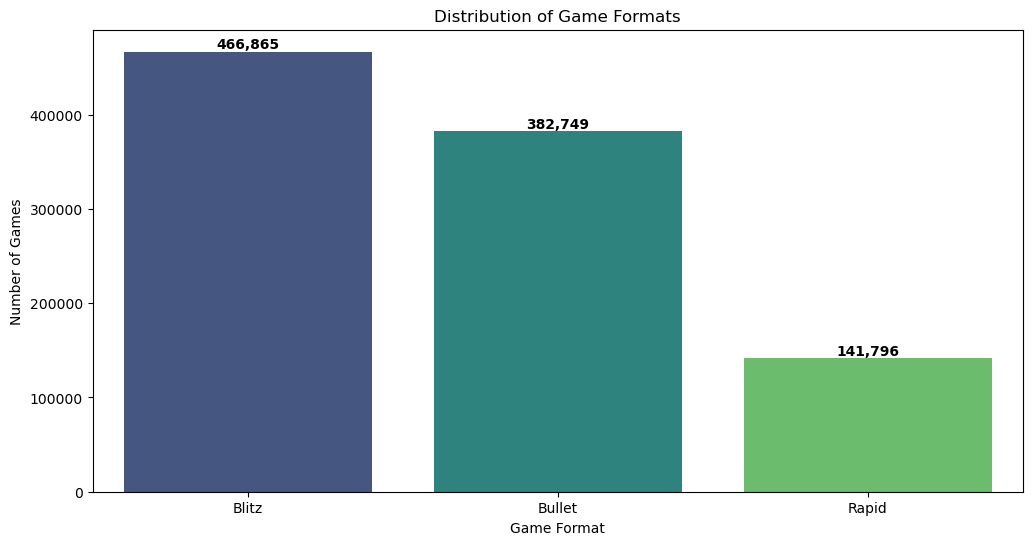

In [10]:
formats_counts = df['Event'].value_counts().reset_index()

plt.figure(figsize=(12,6))

formats_counts.columns = ['Game_Format', 'Count']

ax = sns.barplot(
    data=formats_counts,
    x='Game_Format',
    y='Count',
    hue='Game_Format',
    palette='viridis'
)

for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', fontweight='bold', xytext=(0, 5),
                textcoords='offset points')

plt.title('Distribution of Game Formats')
plt.xlabel('Game Format')
plt.ylabel('Number of Games')
plt.show()

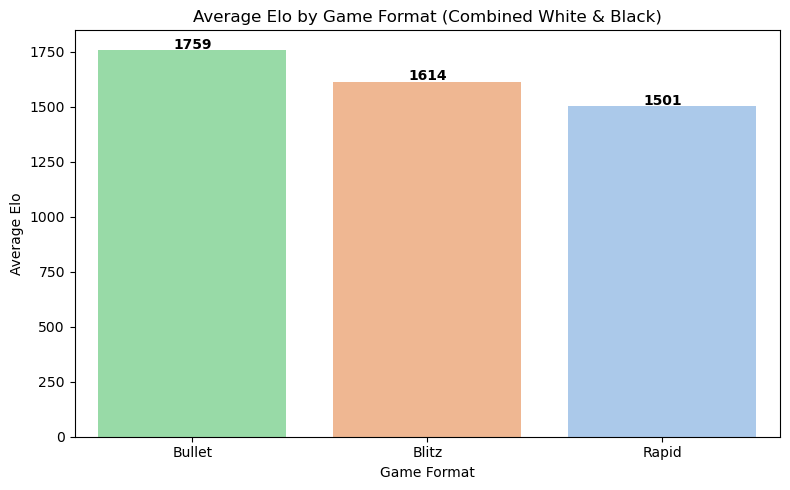

In [11]:
# columns to rows
df.rename(columns={"Event": "Game_Format"}, inplace=True)
df_long = df.melt(id_vars='Game_Format', 
                  value_vars=['WhiteElo', 'BlackElo'], 
                  var_name='Color', value_name='Elo')

# Compute mean Elo per format
mean_elo = df_long.groupby('Game_Format')['Elo'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=mean_elo.index, y=mean_elo.values, hue=mean_elo, palette='pastel', legend=False)

# Add value labels on top of bars
for i, val in enumerate(mean_elo.values):
    ax.text(i, val + 5, f'{val:.0f}', ha='center', fontweight='bold')

plt.title('Average Elo by Game Format (Combined White & Black)')
plt.ylabel('Average Elo')
plt.xlabel('Game Format')
plt.tight_layout()
plt.show()

## 2.2. ANOVA Test: Analysis Of Variance

After computing the average Elo ratings for each game format (Blitz, Bullet, Classical), I noticed that the means were different for each game format. This raised a key question:

> Do these differences in average Elo actually matter, or are they just random?

To answer this, I performed a **one-way ANOVA test**, which is designed to detect whether there are statistically significant differences between the means of multiple groups.

The ANOVA test analyzes player ratings (ELO) across different game formats to assess whether player strength influences the choice of game format.


In [12]:
df_long = df.melt(id_vars='Game_Format', value_vars=['WhiteElo', 'BlackElo'], 
                  var_name='PlayerColor', value_name='Elo')

blitz_elos = df_long[df_long['Game_Format'] == 'Blitz']['Elo']
bullet_elos = df_long[df_long['Game_Format'] == 'Bullet']['Elo']
rapid_elos = df_long[df_long['Game_Format'] == 'Rapid']['Elo']

# Run ANOVA
f_stat, p_val = f_oneway(blitz_elos, bullet_elos, rapid_elos)
print(f"ANOVA F-statistic: {f_stat:.2f}, p-value: {p_val:.4f}")

ANOVA F-statistic: 55106.58, p-value: 0.0000


### Explanation and Analysis

ANOVA (Analysis of Variance) tests whether there are significant differences between the means of multiple groups.

It compares:
- **Between-group variance**: how much the group means differ from the overall mean.
- **Within-group variance**: how much the values in each group vary around their group mean.

### Key Formulas

#### 1 - F-statistic:

$$
F = \frac{MSB}{MSW}
$$

---

### Between-group Variance (MSB)

<div style="display: flex; justify-content: space-between; gap: 30px; margin-top: 20px;">

<div style="width: 32%">

**MSB (Mean Square Between):**

$$
MSB = \frac{SSB}{df_{\text{between}}}
$$

</div>

<div style="width: 32%">

**SSB (Sum of Squares Between):**

$$
SSB = \sum_{i=1}^{k} n_i \left( \bar{x}_i - \bar{x} \right)^2
$$

</div>

<div style="width: 32%">

**df_between:**

$$
df_{\text{between}} = k - 1
$$


</div>
</div>

**Variable definitions:**

- $ \bar{x}_i $ : mean of group *i*  
- $ \bar{x} $ : overall mean  
- $ n_i $ : number of observations in group *i*
- $ df_{\text{between}} $ : degrees of freedom between groups
- $ k $ : number of groups
---

### Within-group Variance (MSW)

<div style="display: flex; justify-content: space-between; gap: 30px; margin-top: 20px;">

<div style="width: 32%">

**MSW (Mean Square Within):**

$$
MSW = \frac{SSW}{df_{\text{within}}}
$$

</div>

<div style="width: 32%">

**SSW (Sum of Squares Within):**

$$
SSW = \sum_{i=1}^{k} \sum_{j=1}^{n_i} \left( x_{ij} - \bar{x}_i \right)^2
$$

</div>

<div style="width: 32%">

**df_within:**

$$
df_{\text{within}} = N - k
$$


</div>
</div>

**Variable definitions:**

- $ x_{ij} $ : j-th observation in group *i*  
- $ \bar{x}_i $ : mean of group *i*  
- $ df_{\text{within}} $ : degrees of freedom inside a group
- $ N $ : total observations
- $ k $ : number of groups

---

#### 2 - p-value

The p-value is the probability of observing an F-statistic as extreme as the one calculated, assuming all group means are equal :

- Small p-value (e.g. < 0.05) → Unlikely the difference is due to chance → Group means are probably different
- Large p-value → The difference could easily happen by chance → Group means are probably the same

It is computed as:

$$
p = P(F_{df_{\text{between}}, df_{\text{within}}} > F_{\text{observed}})
$$

Where:
- $F_{\text{observed}}$ is the calculated F-statistic  
- $df_{\text{between}}$ and $df_{\text{within}}$ are the degrees of freedom

A **small p-value** (typically < 0.05) indicates that at least one group mean is significantly different from the others.


In [13]:
df_long = df.melt(id_vars='Game_Format', value_vars=['WhiteElo', 'BlackElo'], var_name='Color', value_name='Elo')
# Run Tukey HSD
tukey = pairwise_tukeyhsd(endog=df_long['Elo'], groups=df_long['Game_Format'], alpha=0.05)

## 2.3 Tukey HSD Post-hoc Test

After confirming the average Elo ratings per game format:

| Game Format | Average Elo |
|-------------|-------------|
| Bullet      | **1767**    |
| Blitz       | **1618**    |
| Rapid   | **1502**    |

We use Tukey's HSD to determine which **pairs of formats** have significantly different Elo levels.

### Comparison Table
| Comparison         | Mean Difference (Format 1 − Format 2) | p-value | Significant? |
|--------------------|----------------------------------------|---------|---------------|
| **Bullet − Blitz**     | **+148.82 Elo** (Bullet > Blitz)         | < 0.001 | ✅ Yes         |
| **Bullet − Rapid**   | **+264.49 Elo** (Bullet > Rapid)     | < 0.001 | ✅ Yes         |
| **Blitz − Rapid**  | **+115.67 Elo** (Blitz > Rapid)      | < 0.001 | ✅ Yes         |

### Interpretation
- All differences between game formats are statistically significant.
- **Bullet players have the highest average Elo**, followed by Blitz, then Classical.
- The **largest gap** is between **Bullet and Rapid**: nearly 300 Elo points.
- This confirms that different game formats attract players with **distinct skill levels**.


### Analysis : Why Averages Alone Can Be Misleading in this Chess Analysis
While average Elo values suggested that Bullet > Blitz > Classical, relying only on group means can lead to false conclusions. Here’s where I could have been wrong without proper statistical testing :

**1. Different group sizes** : If Bullet had far fewer games than Blitz, a few very strong Bullet players could raise the average unfairly.  
➡ ANOVA adjusts for group sizes, while averages do not.

**2. Elo Ratings with different spread** : Even if Bullet had the highest average, it could also have the widest range of player ratings.  
➡ A group with high Elo variation is less consistent.  
➡ Tukey and ANOVA check both the average and the consistency within groups.

**3. Presence of Outliers**
A few elite 2700+ rated Bullet players could pull the average up, even if most players were 1600–1700.  
➡ Averages can be skewed, but ANOVA detects if such differences are statistically meaningful.


### Conclusion

> Averages give a rough idea.  
> **ANOVA and Tukey confirm if those differences are real.**

By using statistical analysis, I confirmed that the differences between game formats were not just due to random variation, imbalance, or outliers — they are statistically significant.


## 3. Chess Opening Analysis

> *In chess, the **opening** means the first few moves of the game. Players usually follow common patterns at the start because they help develop pieces and control the center of the board.*
>
> *Since there are so many possible ways to begin a game, chess players need a system to organize them.*  
>  
> *That’s where **ECO codes** come in. **ECO** stands for Encyclopaedia of Chess Openings. It’s like a catalog that gives every opening a short label made of a **letter (A–E)** and a **number (00–99)**.*  
>  
> *For example: **C20** → a very basic start with 1. e4 e5 (just moving the king’s pawn two squares, then Black does the same)*  
>  
> *This coding system is widely used in chess literature and databases, making it easier to compare and analyze openings across different sources.*

This section explores chess openings using **ECO codes** to classify and compare games from the dataset. This analysis contains multiple dimensions:

1. **Popularity Analysis** – to understand which openings are most commonly played overall and within different Elo ranges.
2. **Effectiveness Analysis** – to evaluate how well each opening performs in terms of win, draw, and loss rates.
3. **Beginner Friendly Openings** - to analyse games played at an Elo below 1100 and to make recommendations on what are the best openings to learn as a beginner.


## 3.1 Popularity Analysis

In this subsection, I looked at how frequently each ECO-coded opening appears in the dataset.<br>
This helped me identify which openings are popular at beginner, intermediate, and advanced levels — and whether certain openings are preferred or avoided as Elo increases.

> **Preprocessing**  
> - I removed all rows where the ECO code is A00, which represents “Irregular Opening.” (An opening that is not classified in the Database)
>
> - I then applied several preprocessing steps to prepare the data for analysis : 
>   - Calculating the average Elo of both players for each game, 
>   - Creating a new column EloBand to group games into rating bands : *901–1300 , 1301–1700 , 1701–2100 , 2101–2500*
>   - Converting the result values (e.g., "1-0", "0-1", "1/2-1/2") into clearer outcome labels such as *White Win*, *Black Win*, *Draw*.

In [14]:
df_known_openings = df[df['ECO'] != 'A00'].copy()
df_known_openings.loc[:, 'AvgElo'] = (df_known_openings['WhiteElo'] + df_known_openings['BlackElo']) / 2
df_known_openings.loc[:, 'EloBand'] = df_known_openings['AvgElo'].apply(utils.get_elo_band)
df_known_openings.loc[:, 'Outcome']  = df_known_openings['Result'].apply(utils.get_outcome)
elo_filter = ["901–1300", "1301–1700", "1701–2100", "2101–2500"]
filtered_df_known = df_known_openings[df_known_openings['EloBand'].isin(elo_filter)].copy()

#### Top 10 Most Played Openings Overall

In [15]:
grouped = filtered_df_known.groupby(['EloBand', 'ECO']).size().reset_index(name='GameCount')

top10_each = (
    grouped.sort_values(['EloBand', 'GameCount'], ascending=[True, False])
    .groupby('EloBand')
    .head(10)
)
top10_each['ECO_definition'] = top10_each['ECO'].apply(utils.describe_opening)

In [ ]:
band1 = "901–1300"

top_band = top10_each[top10_each['EloBand'] == band1].copy()
top_band['EloBand'] = pd.Categorical(top_band['EloBand'], categories=[band1], ordered=True)

plt.figure(figsize=(14, 4))
ax = sns.barplot(
    data=top_band,
    x="GameCount",
    y="ECO_definition",
    hue="ECO_definition",
    palette="viridis",
    dodge=False,
    legend=False
)

for p in ax.patches:
    ax.text(
        p.get_width() + 5,
        p.get_y() + p.get_height() / 2,
        int(p.get_width()),
        va='center'
    )

plt.title(f"Top 10 Openings in Elo Band {band1}")
plt.xlabel("Game Count")
plt.ylabel("Opening")
plt.tight_layout()
plt.show()

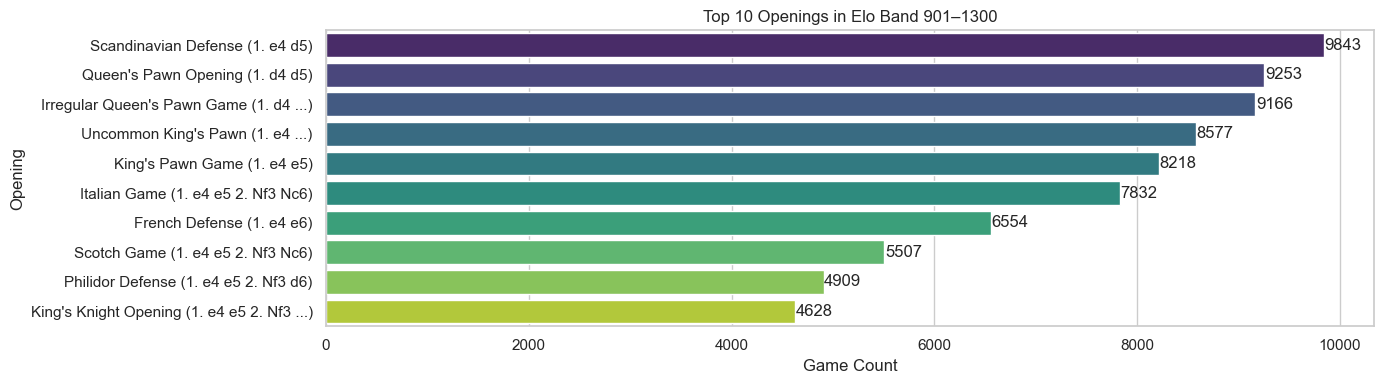 
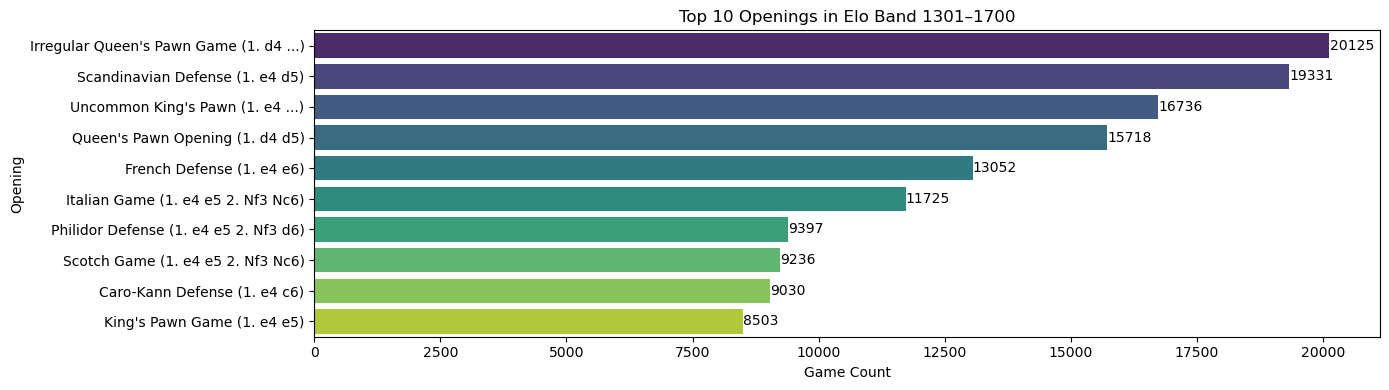
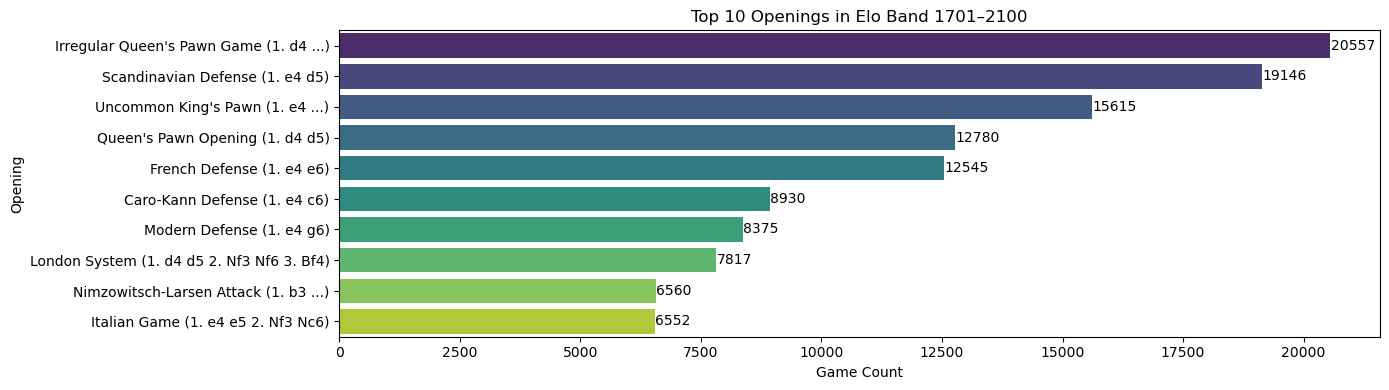
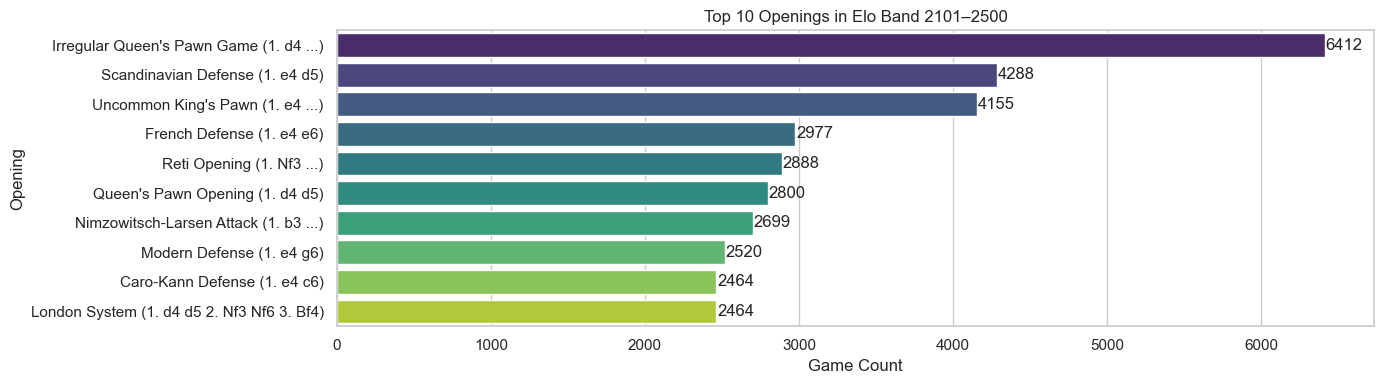

These plots show the most played openings within each rating band.<br>
Across all levels, a few openings dominate — especially the **Irregular Queen’s Pawn Game(1. d4 ...)** and the **Scandinavian Defense(1.e4 d5)**, which remain near the top regardless of Elo. In contrast, some openings appear strongly in one band but drop off in others.<br>

One interesting observation is the **London System**. Despite being simple and easy to learn, it’s not very popular at lower Elo. It becomes more common in higher bands, possibly because stronger players choose it for its solid structure, while beginners may gravitate toward more direct and confrontational openings like the **Italian Game** or **Scandinavian Defense**.<br>

Overall, while the rankings shift between bands, the data shows that certain openings maintain consistent popularity, while others are more dependent on the skill level of the players using them.

## 3.2. Performance of Openings by Time Control

For this part of the project, I explored how different openings perform across various time controls — Bullet, Blitz and Rapid. 
As someone still learning the game, I awas curious to see whether certain openings lead to better results depending on the pace of play. I planned on looking at both White and Black win rates and compare them across time formats for the most effective openings.

In [18]:
filtered_df_known = filtered_df_known[filtered_df_known['ECO'] != '?']

In [19]:
outcome = (filtered_df_known.groupby(['ECO', 'Game_Format', 'Outcome']).size().reset_index(name='Count'))
pivoted = outcome.pivot_table(index=['ECO', 'Game_Format'], columns='Outcome', values='Count', fill_value=0).reset_index()
pivoted['TotalGames'] = pivoted[['WhiteWin', 'Draw', 'BlackWin']].sum(axis=1)
pivoted['WhiteWinRate'] = pivoted['WhiteWin'] / pivoted['TotalGames']
pivoted['DrawRate'] = pivoted['Draw'] / pivoted['TotalGames']
pivoted['BlackWinRate'] = pivoted['BlackWin'] / pivoted['TotalGames']
pivoted['ECO_definition'] = pivoted['ECO'].apply(utils.describe_opening)

In [20]:
pivoted_relevant = pivoted[pivoted['TotalGames'] > 3000]

> In this step, I set an arbitrary threshold of 3,000 games played for an opening to be included. This is an arbitrary choice, but I consider it high enough to make the win rates more statistically meaningful.<br>
> I first selected the top six openings with the highest win rates, regardless of game format. Then, I returned to the original dataset to plot how these openings performed across all game formats.

In [ ]:
top6_rows = pivoted_relevant.sort_values(by='WhiteWinRate', ascending=False).head(6)
top6_openings = top6_rows['ECO_definition'].unique()
subset = pivoted[pivoted['ECO_definition'].isin(top6_openings)]


plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

for i, opening in enumerate(top6_openings):
    data = subset[subset['ECO_definition'] == opening]
    
    plt.subplot(2, 3, i + 1)
    ax = sns.barplot(data=data, x='Game_Format', y='WhiteWinRate', hue='Game_Format', palette='viridis')

    for p, (_, row) in zip(ax.patches, data.iterrows()):
        height = p.get_height()
        # Outside label: win rate
        ax.annotate(f'{height:.4f}',
            (p.get_x() + p.get_width() / 2., height),
            ha='center', va='bottom', fontsize=11, fontweight='bold')
        ax.annotate(f'# Games\n{int(row["TotalGames"])}',
            (p.get_x() + p.get_width() / 2., height / 2),
            ha='center', va='center', fontsize=9, color='white')
    
    plt.title(opening)
    plt.ylim(0, 1)
    plt.ylabel("White Win Rate")
    plt.xlabel("Game Format")
    plt.xticks(rotation=30)

plt.tight_layout()
plt.show()

#### White Best Openings
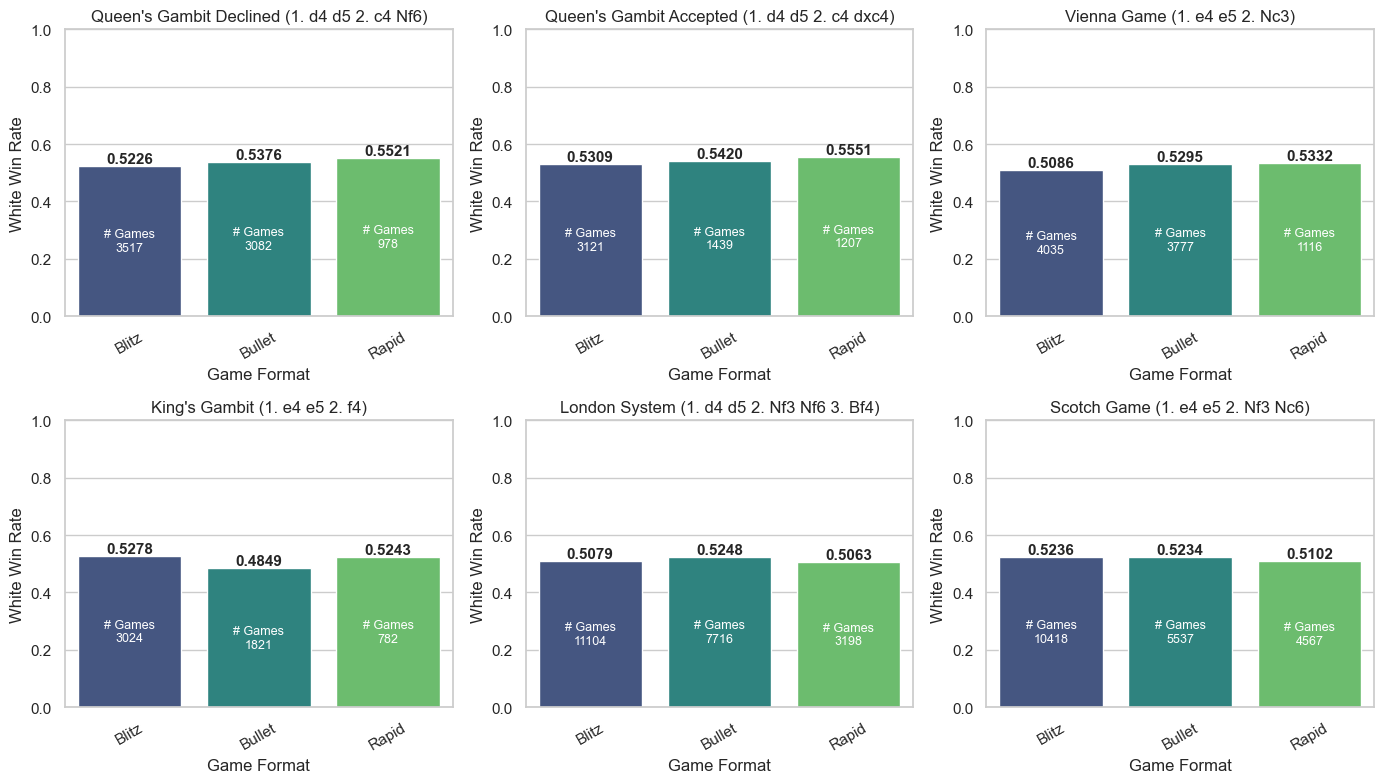

#### Black Best Openings
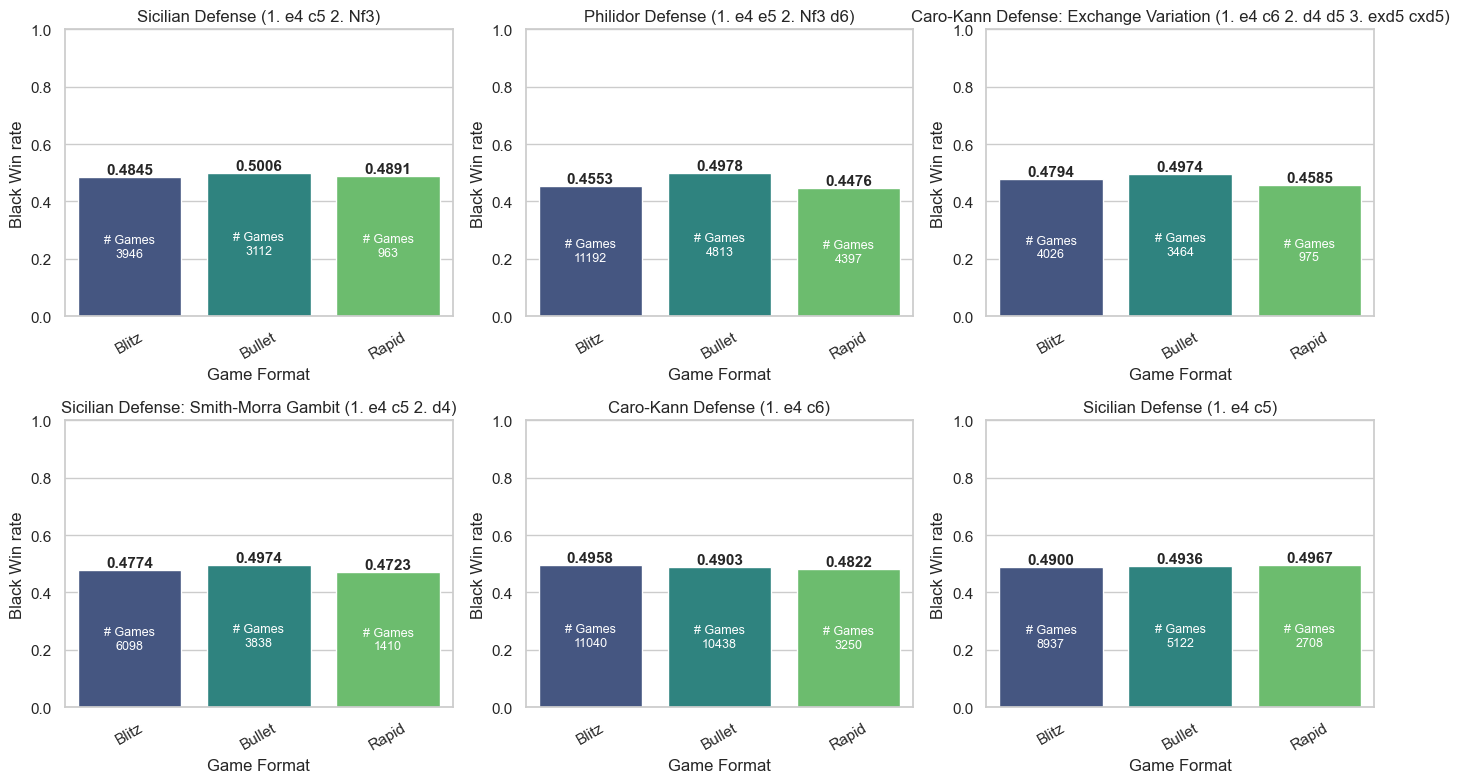

Across the openings shown, most maintain fairly consistent win rates between Blitz, Bullet, and Rapid.<br>
In many cases, the difference from one format to another is minimal and often within a 1–2 percentage point range.<br>
This pattern suggests that the strategic ideas and moves behind these openings are not heavily dependent on time control. Whether a player has only a few minutes on the clock or more time to think, the opening still leads to similar types of middlegame positions and overall results.<br>

For example, the **Queen’s Gambit Declined (1. d4 d5 2. c4 Nf6)** and **Vienna Game (1. e4 e5 2. Nc3)** for White both show stable win rates across formats. These openings tend to create structured, balanced positions where piece development and pawn structure are straightforward, which can help players execute plans quickly in faster games while still holding up well in slower formats.<br> 

On the Black side, openings like the **Caro–Kann Defense** and **Sicilian Defense** also display this consistency. The Caro–Kann, for instance, has clear defensive setups that can be played almost automatically in the first moves, while the Sicilian’s counterattacking structure remains effective whether the game is fast or slow.

This level of stability could make such openings reliable long-term choices for players who want an opening repertoire they can carry across all time controls without needing to make major adjustments.

<table align="center">
<tr>
  <td style="text-align:center; padding: 50px;">
    <img src="../data/King's gambit.png" alt="Position 1" width="700"><br>
    <b>King's Gambit Opening - Black to move</b>
  </td>
  <td style="text-align:center; padding: 50px;">
    <img src="../data/philidor defense.png" alt="Position 2" width="700"><br>
    <b>Philidor Defense - White to move</b>
  </td>
</tr>
</table>


Based on the plots showing the best openings for White and Black, I noticed two openings that behaved differently across time formats: the King’s Gambit and the Philidor Defense. In the King’s Gambit, White’s win rate was about 48% in Bullet but rose to around 52% in Blitz and Rapid. In contrast, the Philidor Defense showed the opposite trend, with Black winning about 49% in Bullet but only 45–44% in Blitz and Rapid.<br>

Clearly both these openings are advantageous to black in bullet, but what could explain this ?<br> 
After doing some research and trying them in a few bullet games myself, here is my hypothesis for why they behave this way :

- <b>King’s Gambit (C30):</b> White sacrifices a pawn early and creates a very sharp position. In Bullet, there’s no time to calculate all the tactics, so White often can’t prove the compensation. Black, on the other hand, can defend with natural moves and quickly gain an advantage from the extra pawn.<br>
- <b>Philidor Defense (C41):</b> Normally considered a passive opening, but in Bullet that can work in Black’s favor. The setup is simple and solid, so Black can play the first moves almost automatically. White, however, has to spend more time thinking about how to break through the structure, which is a disadvantage with so little time on the clock.<br>



#### Conclusion
>*In bullet, time is a big factor. If Black chooses a solid or closed setup, White often has to spend more time deciding how to break through. With so little time on the clock, this can make it harder for White to turn the opening into a clear advantage.<br>*
>*In these situations, Black can sometimes defend comfortably and wait for mistakes.<br>*
>*For White, openings that keep the game active from the start may help reduce the chances of Black settling into a safe position early on.*

## 3.3. Beginner-Friendly Openings

In this section, I focused on games where the average Elo of both players was below 1100. <br>
The goal was to see which openings were most popular and effective among beginners. By looking at this group, I identified openings that gave reasonable chances of success. <br>

The analysis included both sides:

- Openings that worked well for White, giving them a higher win rate in beginner games.

- Openings that favored Black, where beginners scored better when choosing those defenses.

This approach helped me highlight which openings were more accessible to new players, both in terms of popularity and practical results. It also helped me include some of them into my repertoire.<br>

To add more relevency to the data I only included openings that have been played more than 1000 times (aritrary choice)

In [77]:
new_filtered_df_known = df_known_openings[df_known_openings['ECO'] != '?']

beginners_df = new_filtered_df_known[new_filtered_df_known["AvgElo"] < 1100]

opening_counts = (beginners_df.groupby("ECO")["Opening"].count().reset_index(name="GameCount").sort_values(by="GameCount", ascending=False))

winrates = (beginners_df.groupby("ECO")["Outcome"].value_counts(normalize=True).unstack().reset_index())

beginner_openings = opening_counts.merge(winrates, on="ECO")
beginner_openings['ECO_definition'] = beginner_openings['ECO'].apply(utils.describe_opening)

white_favored = beginner_openings[beginner_openings["GameCount"] > 1000].sort_values("WhiteWin", ascending=False)
white_top3 = white_favored.head(3).copy()

white_top3['White Win Rate'] = white_top3['WhiteWin'].map(lambda x: f"{x:.3f}")
white_top3_clean = white_top3[['ECO_definition', 'GameCount', 'White Win Rate']].reset_index(drop=True)


black_favored = beginner_openings[beginner_openings["GameCount"] > 1000].sort_values("BlackWin", ascending=False)
black_top3 = black_favored.head(3).copy()

black_top3['Black Win Rate'] = black_top3['BlackWin'].map(lambda x: f"{x:.3f}")
black_top3_clean = black_top3[['ECO_definition', 'GameCount', 'Black Win Rate']].reset_index(drop=True)


display(white_top3_clean)
display(black_top3_clean)

,ECO_definition,GameCount,White Win Rate
0,Petrov's Defense (1. e4 e5 2. Nf3 Nf6),2294,0.548
1,Bishop’s Opening (1. e4 e5 2. Bc4),2051,0.547
2,King's Knight Opening (1. e4 e5 2. Nf3 ...),3225,0.546


,ECO_definition,GameCount,Black Win Rate
0,Sicilian Defense (1. e4 c5),1130,0.531
1,Caro-Kann Defense (1. e4 c6),2001,0.504
2,Zukertort Opening (1. Nf3),1202,0.498


#### Top 3 Openings for White

<table align="center">
<tr>
  <td style="text-align:center; padding: 50px;">
    <img src="../data/Petrov's Defense.png" alt="Position 1" width="700"><br>
    <b>Petrov's Defense - 54.8% Win rate</b>
  </td>
  <td style="text-align:center; padding: 50px;">
    <img src="../data/Bishop’s Opening.png" alt="Position 2" width="700"><br>
    <b>Bishop’s Opening - 54.7% Win rate</b>
  </td>
  <td style="text-align:center; padding: 50px;">
    <img src="../data/King's Knight Opening.png" alt="Position 1" width="700"><br>
    <b>King's Knight Opening (Any response other than Nf3 from Black) - 54.6% Win rate</b>
  </td>
</tr>
</table>


#### Top 3 Openings for Black

<table align="center">
<tr>
  <td style="text-align:center; padding: 50px;">
    <img src="../data/Sicilian Defense.png" alt="Position 1" width="700"><br>
    <b>Sicilian Defense - 53.1% Win rate</b>
  </td>
  <td style="text-align:center; padding: 50px;">
    <img src="../data/Caro-Kann Defense.png" alt="Position 2" width="700"><br>
    <b>Caro-Kann Defense - 50.4% Win rate</b>
  </td>
  <td style="text-align:center; padding: 50px;">
    <img src="../data/Zukertort Opening.png" alt="Position 1" width="700"><br>
    <b>Zukertort Opening - 49.8% Win rate</b>
  </td>
</tr>
</table>

##### Conclusion and Recommendations
When I looked at games from players rated under 1100, a few openings stood out as especially good for beginners. For White, the best results came from the Petrov’s Defense, the Bishop’s Opening, and the King’s Knight Opening.<br>
For Black, the Sicilian Defense and the Caro–Kann Defense worked really well, and the Zukertort Opening also showed up as a solid choice.<br>

What makes these openings good is that they are simple to play and easy to understand. They don’t need a lot of memorization or deep theory, they focus on basic ideas like developing pieces and controlling the center.<br> 
Openings like the Caro–Kann give Black a solid setup that can be played almost the same way every game. On the other hand, the Bishop’s Opening helps White get quick development and space without making the position too complicated.<br>

These openings are also easier to study compared to others. They have fewer tricky variations and more clear plans, which is perfect for players who are still learning.<br>

Additionally, when I looked at the games from Black’s point of view, it was clear that playing with the Black pieces usually came with a higher chance of losing. The main reason was that White dictates the pace of the game by making the first move. This means that Black often has to react in the opening and try to equalize before looking for any advantage. On top of that, in the lower rating levels (cf section 2.1), most games started with 1. e4 from White.<br>
<br>
<br>
With this in mind, my recommendations are : 
<br>
<br>

> **Bishop’s Opening (as White) - Simple and Attacking**<br>
>
>*I recommend the Bishop’s Opening for beginners who want to learn active piece play without memorizing heavy theory. By developing the bishop early to c4, White immediately puts pressure on the weak f7 square and prepares smooth development of the knights. The opening often leads to open positions where tactics appear naturally, which is useful for practicing attacking ideas and learning how to coordinate pieces. It is a good choice for players who want to practice basic opening principles like development, center control, and piece activity in a clear and straightforward way.*<br>
><br>
><br>
>**Sicilian Defense (as Black) - Sharp and Complex**<br>
>
>*I recommend the Sicilian Defense for players who want to fight for the win with Black instead of just defending. By playing 1…c5, Black challenges the center from the side instead of mirroring White’s pawn move, which often leads to asymmetrical and unbalanced positions. This makes the games more dynamic and teaches players how to play for counterplay rather than only reacting. However, the Sicilian has many variations, so it does require more study than other beginner options. It is a great opening for players who enjoy active, fighting positions and are willing to spend a bit of extra effort learning the main ideas.*<br>
><br>
><br>
>**Caro–Kann Defense (as Black) - Safest**<br>
>
>*I recommend the Caro–Kann Defense for beginners who want something solid and reliable. With 1…c6 followed by 2…d5, Black builds a strong pawn structure that is difficult for White to break down. The ideas are usually straightforward: develop the knights, put the bishop on f5 or g4, and get the king safe. Unlike the Sicilian, the Caro–Kann often leads to slower, positional games where plans are easier to understand. This makes it an excellent training tool for learning patience, structure, and long-term planning. For players who want consistency and less tactical chaos, the Caro–Kann is one of the best openings to start with.*
